<a href="https://colab.research.google.com/github/leonardoub/cmepda/blob/master/BRATS_Kfold_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

#Load data

In [2]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
dataset_path = '/gdrive/My Drive/BRATS/data_without_NAN_without_HISTO_with_histologies.csv'

In [0]:
df_data = pd.read_csv(dataset_path)

In [5]:
df_data

,ID,Date,VOLUME_ET,VOLUME_NET,VOLUME_ED,VOLUME_TC,VOLUME_WT,VOLUME_BRAIN,VOLUME_ET_OVER_NET,VOLUME_ET_OVER_ED,VOLUME_NET_OVER_ED,VOLUME_ET_over_TC,VOLUME_NET_over_TC,VOLUME_ED_over_TC,VOLUME_ET_OVER_WT,VOLUME_NET_OVER_WT,VOLUME_ED_OVER_WT,VOLUME_TC_OVER_WT,VOLUME_ET_OVER_BRAIN,VOLUME_NET_OVER_BRAIN,VOLUME_ED_over_BRAIN,VOLUME_TC_over_BRAIN,VOLUME_WT_OVER_BRAIN,DIST_Vent_TC,DIST_Vent_ED,INTENSITY_Mean_ET_T1Gd,INTENSITY_STD_ET_T1Gd,INTENSITY_Mean_ET_T1,INTENSITY_STD_ET_T1,INTENSITY_Mean_ET_T2,INTENSITY_STD_ET_T2,INTENSITY_Mean_ET_FLAIR,INTENSITY_STD_ET_FLAIR,INTENSITY_Mean_NET_T1Gd,INTENSITY_STD_NET_T1Gd,INTENSITY_Mean_NET_T1,INTENSITY_STD_NET_T1,INTENSITY_Mean_NET_T2,INTENSITY_STD_NET_T2,INTENSITY_Mean_NET_FLAIR,...,TEXTURE_NGTDM_ED_T1_Busyness,TEXTURE_NGTDM_ED_T1_Complexity,TEXTURE_NGTDM_ED_T1_Strength,TEXTURE_NGTDM_ED_T2_Coarseness,TEXTURE_NGTDM_ED_T2_Contrast,TEXTURE_NGTDM_ED_T2_Busyness,TEXTURE_NGTDM_ED_T2_Complexity,TEXTURE_NGTDM_ED_T2_Strength,TEXTURE_NGTDM_ED_FLAIR_Coarseness,TEXTURE_NGTDM_ED_FLAIR_Contrast,TEXTURE_NGTDM_ED_FLAIR_Busyness,TEXTURE_NGTDM_ED_FLAIR_Complexity,TEXTURE_NGTDM_ED_FLAIR_Strength,TEXTURE_NGTDM_NET_T1Gd_Coarseness,TEXTURE_NGTDM_NET_T1Gd_Contrast,TEXTURE_NGTDM_NET_T1Gd_Busyness,TEXTURE_NGTDM_NET_T1Gd_Complexity,TEXTURE_NGTDM_NET_T1Gd_Strength,TEXTURE_NGTDM_NET_T1_Coarseness,TEXTURE_NGTDM_NET_T1_Contrast,TEXTURE_NGTDM_NET_T1_Busyness,TEXTURE_NGTDM_NET_T1_Complexity,TEXTURE_NGTDM_NET_T1_Strength,TEXTURE_NGTDM_NET_T2_Coarseness,TEXTURE_NGTDM_NET_T2_Contrast,TEXTURE_NGTDM_NET_T2_Busyness,TEXTURE_NGTDM_NET_T2_Complexity,TEXTURE_NGTDM_NET_T2_Strength,TEXTURE_NGTDM_NET_FLAIR_Coarseness,TEXTURE_NGTDM_NET_FLAIR_Contrast,TEXTURE_NGTDM_NET_FLAIR_Busyness,TEXTURE_NGTDM_NET_FLAIR_Complexity,TEXTURE_NGTDM_NET_FLAIR_Strength,TGM_p1,TGM_dw,TGM_Cog_X_1,TGM_Cog_Y_1,TGM_Cog_Z_1,TGM_T_1,Histology
0,TCGA-02-0006,1996.08.23,1662,384,36268,2046,38314,1469432,4.328125,0.045826,0.010588,0.812320,0.187680,17.726300,0.043378,0.010022,0.946599,0.053401,0.001131,0.000261,0.024682,0.001392,0.026074,31.5903,2.7735,149.7977,10.4671,194.1422,15.1037,154.9225,43.4709,220.5894,30.2917,137.8881,6.3820,183.6933,14.8846,161.1005,35.8591,227.7510,...,0.86315,1479.9762,1.10870,0.000605,0.40937,1.47070,2992.2698,0.71642,0.000690,0.28977,1.8815,1872.0528,0.75986,0.026040,0.37869,0.060929,1675.0041,14.11380,0.044156,0.41942,0.026740,2536.7559,43.31290,0.036634,0.50304,0.024264,3593.3279,43.67590,0.057204,0.33980,0.021897,2203.2034,61.32930,8.00000,7.500000e-07,0.178609,0.096256,0.052741,2.00000,GBM
1,TCGA-02-0009,1997.06.14,4362,4349,15723,8711,24434,1295721,1.002989,0.277428,0.276601,0.500750,0.499250,1.805000,0.178522,0.177990,0.643489,0.356511,0.003366,0.003356,0.012135,0.006723,0.018857,9.2443,3.0207,165.4345,6.4047,201.2400,13.4733,113.1601,10.1373,210.1810,15.9543,152.6013,4.2360,188.0607,11.1316,116.8538,10.0992,209.7901,...,0.40004,2378.9184,2.54730,0.000914,0.70926,0.78063,5719.2847,1.29980,0.000882,0.48919,1.8243,2954.8148,0.77199,0.002254,0.29324,1.223600,539.3057,0.53125,0.005712,0.20995,0.315580,967.7845,3.74440,0.003790,0.36163,0.271420,1996.1440,2.77050,0.004966,0.28715,0.189980,1440.4285,3.59990,3.31250,1.000000e-09,0.077618,0.122900,0.094336,91.47360,GBM
2,TCGA-02-0011,1998.02.01,33404,48612,45798,82016,127814,1425843,0.687155,0.729377,1.061444,0.407290,0.592710,0.558400,0.261349,0.380334,0.358318,0.641682,0.023428,0.034094,0.032120,0.057521,0.089641,1.0000,1.0000,186.3385,17.6126,188.2019,23.5195,172.8969,32.7401,167.1395,34.1684,149.0643,12.9090,158.4197,15.2632,197.4966,27.1781,165.1014,...,1.51780,1750.3404,0.56482,0.000382,0.59301,1.81810,4990.3388,0.54747,0.000345,0.59184,2.4243,4703.9458,0.41937,0.000403,0.37863,1.957500,2509.3979,0.42842,0.000768,0.19849,1.395800,1322.6082,0.74730,0.000634,0.31856,1.144300,2517.8629,0.84294,0.000794,0.17961,1.068800,1147.5177,0.80480,5.78125,1.000000e-09,0.132283,0.116006,0.096035,272.42900,GBM
3,TCGA-02-0027,1999.03.28,12114,7587,34086,19701,53787,1403429,1.596679,0.355395,0.222584,

In [6]:
df_data.columns

Index(['ID', 'Date', 'VOLUME_ET', 'VOLUME_NET', 'VOLUME_ED', 'VOLUME_TC',
       'VOLUME_WT', 'VOLUME_BRAIN', 'VOLUME_ET_OVER_NET', 'VOLUME_ET_OVER_ED',
       ...
       'TEXTURE_NGTDM_NET_FLAIR_Busyness',
       'TEXTURE_NGTDM_NET_FLAIR_Complexity',
       'TEXTURE_NGTDM_NET_FLAIR_Strength', 'TGM_p1', 'TGM_dw', 'TGM_Cog_X_1',
       'TGM_Cog_Y_1', 'TGM_Cog_Z_1', 'TGM_T_1', 'Histology'],
      dtype='object', length=587)

In [0]:
data = df_data.drop(['Histology', 'ID', 'Date'], axis=1)

In [0]:
labels = df_data.Histology

##Encode labels

In [0]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
labels_enc = encoder.fit_transform(labels)

##Building Network

In [10]:
import keras
from keras import layers
from keras.preprocessing import sequence

Using TensorFlow backend.


In [0]:
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.optimizers import SGD

In [0]:
from keras import regularizers

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(20, activation='relu', input_shape=(584,), kernel_regularizer=regularizers.l2(l=0.05)))
  #model.add(layers.Dropout(0.01))
  #model.add(layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(l=0.05)))
  #model.add(layers.Dropout(0.01))

  model.add(layers.Dense(1, activation='sigmoid'))

  sgd = SGD(lr=0.05, momentum=0.9)
  adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
  rmsprop = RMSprop(lr=0.001)

  model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [0]:
from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau('val_loss', patience=10, verbose=1, factor=0.1, min_lr=0.0001)
#usandolo la loss non scende anche se non agisce, COME MAI????
#non usandolo e non variando nient'altro la loss scende molto rapidamente

In [15]:
num_epochs = 500

model = build_model()
history = model.fit(train_data_stand, train_labels_enc, validation_data=(val_data_stand, val_labels_enc), 
                      epochs= num_epochs, batch_size=92, callbacks=[red_lr])
  

acc_history = history.history['accuracy']
loss_history = history.history['loss']
acc_val_history = history.history['val_accuracy']
loss_val_history = history.history['val_loss']


NameError: ignored

#Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [18]:
for train_index, test_index in skf.split(data, labels_enc):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  29  30  31  33  34  35  36  37  38  39
  40  41  42  43  44  45  47  48  49  50  51  52  53  54  55  57  58  59
  60  61  63  64  65  66  68  70  71  72  73  74  76  78  79  81  82  84
  87  88  90  91  94  95  97  99 101 102 104 106 108 109 110 111 112 114
 115 116 117 118 120 121 122 123 125 127 128 129 130 131 132 133 134 135
 136 137 138 141 142 143 144 145] TEST: [  2  27  28  32  46  56  62  67  69  75  77  80  83  85  86  89  92  93
  96  98 100 103 105 107 113 119 124 126 139 140]
TRAIN: [  0   1   2   3   5   6   7   8   9  10  11  13  14  16  17  18  19  25
  26  27  28  29  30  31  32  34  35  36  37  38  39  40  43  44  45  46
  47  49  50  52  53  54  56  57  58  59  61  62  63  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  83  84  85  86  87  89  90  91
  92  93  94  95  96  97  98  99 100 102 103 104 105 107 109 110 111 112
 113 114 115 116 118

In [0]:
from keras.utils import to_categorical


In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

Train on 116 samples, validate on 30 samples
Epoch 1/100
116/116 [==============================] - 0s 857us/step - loss: 2.5359 - accuracy: 0.4655 - val_loss: 1.9355 - val_accuracy: 0.7000
Epoch 2/100
116/116 [==============================] - 0s 93us/step - loss: 1.8994 - accuracy: 0.6983 - val_loss: 1.3256 - val_accuracy: 0.7667
Epoch 3/100
116/116 [==============================] - 0s 84us/step - loss: 1.3120 - accuracy: 0.7500 - val_loss: 1.0088 - val_accuracy: 0.7333
Epoch 4/100
116/116 [==============================] - 0s 80us/step - loss: 1.0123 - accuracy: 0.7069 - val_loss: 0.8062 - val_accuracy: 0.8333
Epoch 5/100
116/116 [==============================] - 0s 80us/step - loss: 0.8353 - accuracy: 0.8190 - val_loss: 0.7118 - val_accuracy: 0.7667
Epoch 6/100
116/116 [==============================] - 0s 79us/step - loss: 0.7619 - accuracy: 0.7500 - val_loss: 0.6670 - val_accuracy: 0.8333
Epoch 7/100
116/116 [==============================] - 0s 62us/step - loss: 0.6984 - accur

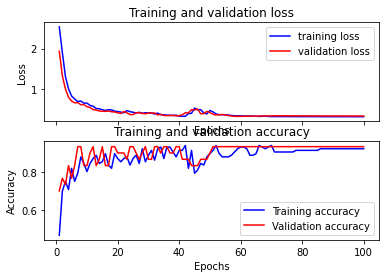

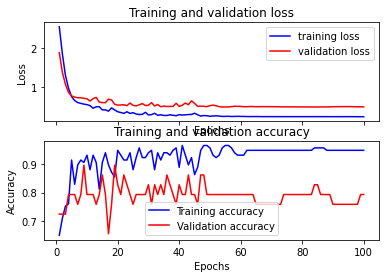

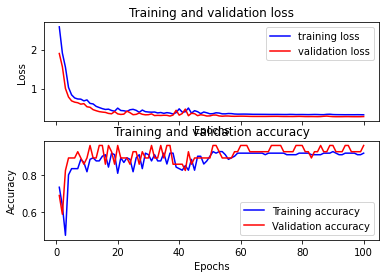

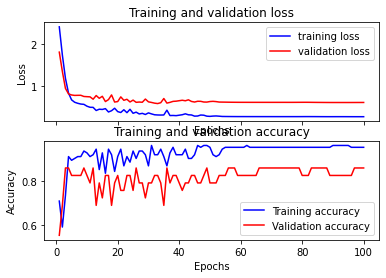

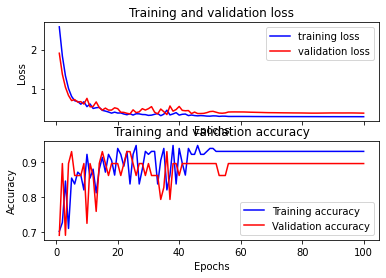

In [34]:
num_epochs = 100
all_acc_histories = []
all_loss_histories = []
all_val_acc_histories = []
all_val_loss_histories = []
cvscores = []

for train_index, val_index in skf.split(data, labels_enc):
 
  partial_train_data = data.iloc[train_index, :]
  partial_train_targets = labels_enc[train_index]
  
  val_data = data.iloc[val_index, :]
  val_targets = labels_enc[val_index]

  scaler = MinMaxScaler()
  partial_train_data_scaled = scaler.fit_transform(partial_train_data)
  val_data_scaled = scaler.transform(val_data)
 
  model = build_model()
  history = model.fit(partial_train_data_scaled, partial_train_targets, validation_data=(val_data_scaled, val_targets), 
                      epochs=num_epochs, batch_size=92, callbacks=[red_lr])
  
  acc_history = history.history['accuracy']
  all_acc_histories.append(acc_history)

  loss_history = history.history['loss']
  all_loss_histories.append(loss_history)

  acc_val_history = history.history['val_accuracy']
  all_val_acc_histories.append(acc_val_history)

  loss_val_history = history.history['val_loss']
  all_val_loss_histories.append(loss_val_history)
  
  scores = model.evaluate(val_data_scaled, val_targets)
  cvscores.append(scores)

  epochs = range(1, num_epochs+1)


  fig, (ax1, ax2) = plt.subplots(2, sharex=True)
  #fig.suptitle('Horizontally stacked subplots')
  ax1.plot(epochs, loss_history, 'b', label='training loss')
  ax1.plot(epochs, loss_val_history, 'r', label='validation loss')
  ax1.set_title('Training and validation loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()

  ax2.plot(epochs, acc_history, 'b', label='Training accuracy')
  ax2.plot(epochs, acc_val_history, 'r', label='Validation accuracy')
  ax2.set_title('Training and validation accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.legend() 

  fig.show()
#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

In [0]:
history_dict = history.history 

In [0]:
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])

In [41]:
cvscores

[[0.3445780277252197, 0.9333333373069763],
 [0.5001296997070312, 0.7931034564971924],
 [0.27942439913749695, 0.9655172228813171],
 [0.5975377559661865, 0.8620689511299133],
 [0.3994888365268707, 0.8965517282485962]]

In [0]:
loss_array = np.array([cvscores[i][0] for i in range(0,5)])

In [0]:
acc_array = np.array([cvscores[i][1] for i in range(0,5)])

In [60]:
loss_array

array([0.34457803, 0.5001297 , 0.2794244 , 0.59753776, 0.39948884])

In [62]:
acc_array

array([0.93333334, 0.79310346, 0.96551722, 0.86206895, 0.89655173])

In [67]:
mean_loss = loss_array.mean()
print(mean_loss)

0.424231743812561


In [70]:
mean_acc = acc_array.mean()
std_acc = acc_array.std()
print(mean_acc)
print(std_acc)

0.890114939212799
0.05965328456266534


In [0]:
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]


In [0]:
len(average_val_acc_history)

100

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

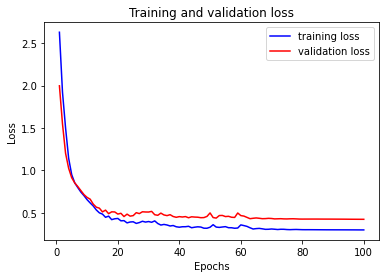

In [0]:
plt.plot(epochs, average_loss_history, 'b', label='training loss')
plt.plot(epochs, average_val_loss_history, 'r', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

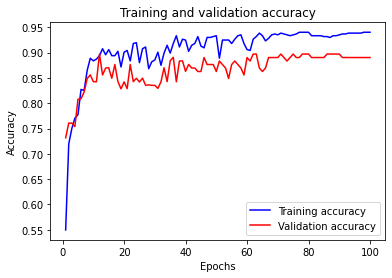

In [0]:
plt.plot(epochs, average_acc_history, 'b', label='Training accuracy')
plt.plot(epochs, average_val_acc_history, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 